In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)


In [2]:
import os

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
DATA_PATH = os.path.join(PROJECT_ROOT, "data", "raw", "events_raw.csv")

df = pd.read_csv(DATA_PATH, parse_dates=["event_time", "first_event_time"])
df.head()


,user_id,event_time,event_type,used_choptrack,used_chopguide,first_event_time,days_since_first,retained_7d
0,1,2025-02-21 11:00:00,view_recipe,False,False,2025-02-21 11:00:00,0,False
1,1,2025-02-22 10:00:00,use_choptrack,True,False,2025-02-21 11:00:00,0,False
2,1,2025-02-24 17:00:00,view_recipe,False,False,2025-02-21 11:00:00,3,False
3,1,2025-02-25 18:00:00,save_recipe,False,False,2025-02-21 11:00:00,4,False
4,1,2025-03-03 12:00:00,login,False,False,2025-02-21 11:00:00,10,True


In [3]:
df.info()
df.describe(include="all")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13010 entries, 0 to 13009
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   user_id           13010 non-null  int64         
 1   event_time        13010 non-null  datetime64[ns]
 2   event_type        13010 non-null  object        
 3   used_choptrack    13010 non-null  bool          
 4   used_chopguide    13010 non-null  bool          
 5   first_event_time  13010 non-null  datetime64[ns]
 6   days_since_first  13010 non-null  int64         
 7   retained_7d       13010 non-null  bool          
dtypes: bool(3), datetime64[ns](2), int64(2), object(1)
memory usage: 546.4+ KB


,user_id,event_time,event_type,used_choptrack,used_chopguide,first_event_time,days_since_first,retained_7d
count,13010.000000,13010,13010,13010,13010,13010,13010.000000,13010
unique,NaN,NaN,6,2,2,NaN,NaN,2
top,NaN,NaN,view_recipe,False,False,NaN,NaN,True
freq,NaN,NaN,3211,10336,11078,NaN,NaN,9040
mean,250.333359,2025-03-07 21:36:47.870868480,NaN,NaN,NaN,2025-02-14 11:08:28.316679424,20.993467,NaN
min,1.000000,2025-01-01 02:00:00,NaN,NaN,NaN,2025-01-01 02:00:00,0.000000,NaN
25%,125.000000,2025-02-23 13:00:00,NaN,NaN,NaN,2025-01-22 12:00:00,4.000000,NaN
50%,250.000000,2025-03-13 07:00:00,NaN,NaN,NaN,2025-02-15 11:00:00,15.000000,NaN
75%,374.000000,2025-03-24 18:00:00,NaN,NaN,NaN,2025-03-07 04:00:00,33.000000,NaN
max,500.000000,2025-03-31 00:00:00,NaN,NaN,NaN,2025-03-31 00:00:00,87.000000,NaN


In [4]:
user_features = (
    df.groupby("user_id")
      .agg(
          used_choptrack=("used_choptrack", "max"),
          used_chopguide=("used_chopguide", "max"),
          retained_7d=("retained_7d", "max"),
          total_events=("event_type", "count"),
          active_days=("days_since_first", "max")
      )
      .reset_index()
)

user_features.head()


,user_id,used_choptrack,used_chopguide,retained_7d,total_events,active_days
0,1,True,True,True,17,36
1,2,True,True,True,16,69
2,3,True,True,True,46,17
3,4,True,True,True,32,28
4,5,True,False,True,25,59


In [5]:
def feature_group(row):
    if row.used_choptrack and row.used_chopguide:
        return "Both"
    elif row.used_choptrack:
        return "ChopTrack only"
    elif row.used_chopguide:
        return "ChopGuide only"
    else:
        return "None"

user_features["feature_group"] = user_features.apply(feature_group, axis=1)
user_features["feature_group"].value_counts()


feature_group
Both              458
ChopTrack only     28
ChopGuide only     12
None                2
Name: count, dtype: int64

In [6]:
retention_by_feature = (
    user_features
    .groupby("feature_group")["retained_7d"]
    .mean()
    .reset_index()
    .sort_values("retained_7d", ascending=False)
)

retention_by_feature


,feature_group,retained_7d
3,None,1.000000
1,ChopGuide only,0.916667
0,Both,0.901747
2,ChopTrack only,0.892857


/var/folders/8g/zv0955h54s17sjwt7_k9btb40000gn/T/ipykernel_53401/922516892.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


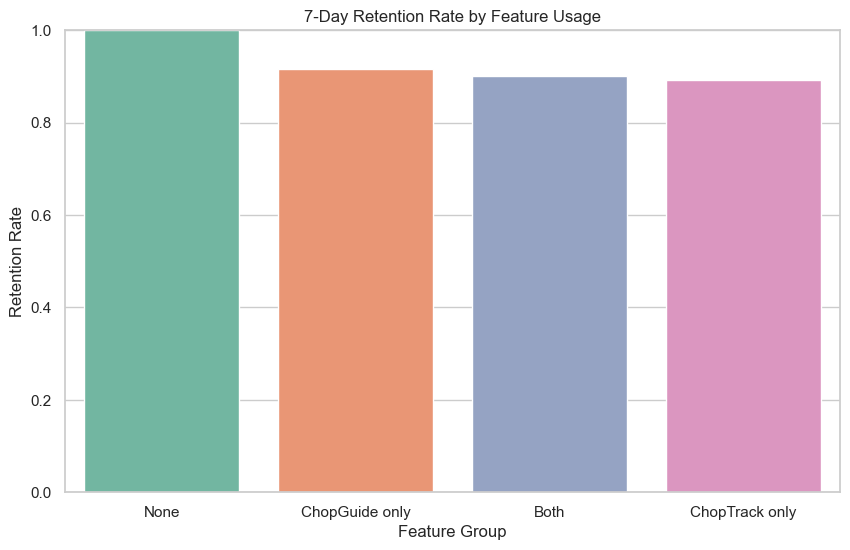

In [7]:
sns.barplot(
    data=retention_by_feature,
    x="feature_group",
    y="retained_7d",
    palette="Set2"
)

plt.title("7-Day Retention Rate by Feature Usage")
plt.ylabel("Retention Rate")
plt.xlabel("Feature Group")
plt.ylim(0, 1)
plt.show()


/var/folders/8g/zv0955h54s17sjwt7_k9btb40000gn/T/ipykernel_53401/1999753587.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


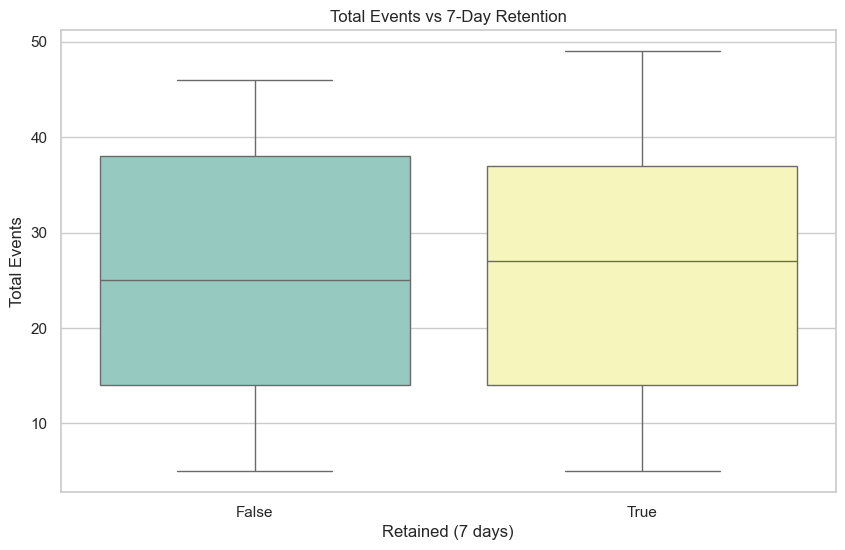

In [8]:
sns.boxplot(
    data=user_features,
    x="retained_7d",
    y="total_events",
    palette="Set3"
)

plt.title("Total Events vs 7-Day Retention")
plt.xlabel("Retained (7 days)")
plt.ylabel("Total Events")
plt.show()


### Key Findings
- Users who used ChopTrack showed higher 7-day retention than those who only used ChopGuide.
- Combined usage of ChopTrack and ChopGuide resulted in the highest retention.
- Higher early engagement (more events) strongly correlates with retention.
